In [1]:
%matplotlib inline

import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl_update = {'font.size':16,
              'xtick.labelsize':14,
              'ytick.labelsize':14,
              'figure.figsize':[12.0,8.0],
              'axes.color_cycle':['#0055A7', '#2C3E4F', '#26C5ED', '#00cc66', '#D34100', '#FF9700','#091D32'], 
              'axes.labelsize':16,
              'axes.labelcolor':'#677385',
              'axes.titlesize':20,
              'lines.color':'#0055A7',
              'lines.linewidth':2,
              'text.color':'#677385'}
mpl.rcParams.update(mpl_update)

default_colors=['#0055A7', 'orange', '#26C5ED']

/Users/fausto/miniconda3/envs/insightpy3/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import os

# Functions 

In [3]:
def make_plots(df, t0='2017-08-10 22:00:00', t1='2017-08-11 09:00:00', 
               label_size=20, rotation=90, ax=None, color='#0055A7',
               max_value=128, fig_height=40, fig_width=14, grid=False, title='', 
               first_legend_label='_nolegend_', xlabel='Server',
               file_to_save=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))
        return_ax_only=False
    else:
        return_ax_only=True
    
    width = 1
    labels = []
    xlim = [pd.to_datetime(t0), pd.to_datetime(t1)]
    

    for i, (server_id, server) in enumerate(df.groupby('server_id')):
        labsplit = server_id.split('.')
        labels.append(labsplit[0] if len(labsplit)==1 else labsplit[1])
        y0 = i - 0.5*width    

        # scale memory value to be between 0 and 1
        y = server['value'] / max_value

        ax.axhline(y0, color='gray', lw=0.5)
        ax.axhline(y0 + width, color='gray', lw=0.5)
        if i==0:
            ax.plot(server['timestamp'], y0 + y*width, label=first_legend_label,
                color=color, marker='.', lw=0, markersize=2.5)
        else:
            ax.plot(server['timestamp'], y0 + y*width, label='_nolegend_',
                color=color, marker='.', lw=0, markersize=2.5)

    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    plt.xticks(rotation=rotation);
    
    ax.set_ylabel(xlabel, size=label_size)
    ax.set_xlabel('Time', size=label_size)
    ax.set_ylim(-0.5, i+0.5)
    ax.set_xlim(xlim)
    
    ax.set_title(title)
    
    ax.grid(grid)
    
    if file_to_save: 
        fig.savefig(file_to_save, dpi = 300)
    
    plt.close()
    

    if return_ax_only:
        return ax
    else:
        return fig, ax

In [4]:
def plot_multiple(dfs, t0, t1, max_values, legend_labels, 
                  colors= default_colors,
                  title='',
                 fig_height=40, **kwargs):
    fig, ax = plt.subplots(figsize=(14, fig_height))
    for i, df in enumerate(dfs):
        ax  = make_plots(df, t0, t1,  
                         ax=ax, max_value=max_values[i], title=title,
                         color=colors[i], first_legend_label=legend_labels[i], **kwargs)
    ax.legend(loc=2)
    return fig, ax
        

In [5]:
def get_aggregate(dfs, max_vals, mean_labels, agg_function=np.mean):
    for i, df in enumerate(dfs):
        df_mean = pd.DataFrame(df.groupby('timestamp').value.apply(agg_function).divide(max_vals[i])).reset_index()
        df_mean['server_id'] = [mean_labels[i]]*len(df_mean)
        if i==0:
            df_out = df_mean.copy(deep=True)
        else:
            df_out = df_out.append(df_mean.copy(deep=True))
    
    return df_out

In [6]:
def sum_network(network_df):
    network_df['rx'] = network_df['server_id'].apply(lambda x: x.split('.')[-1])
    network_df['server'] = network_df['server_id'].apply(lambda x: '.'.join(x.split('.')[:-1]))
    df_agg = network_df.groupby(['server','timestamp']).value.sum()
    df_agg = pd.DataFrame(df_agg).reset_index()
    return df_agg

In [7]:
def plot_all(dfs, t0, t1, max_vals, mean_labels, legend_labels, agg_function=np.mean, **kwargs):
    plot_dfs = []
    for row in dfs:
        df = get_aggregate(row, max_vals, mean_labels, 
                           agg_function=agg_function)
        plot_dfs.append(df)
        
    fig, ax = plot_multiple(plot_dfs, t0, t1, [1,1,1], legend_labels, 
                            **kwargs)
    
    return fig, ax

# Load files

In [8]:
files = os.listdir('../data/final/')

In [9]:
files

['compute_cpu_full.csv',
 'compute_memory_full.csv',
 'compute_network_full.csv',
 'gateway_cpu_full.csv',
 'gateway_memory_full.csv',
 'gateway_network_full.csv',
 'osd_cpu_full.csv',
 'osd_memory_full.csv',
 'osd_network_full.csv']

In [10]:
compute = []
gateway = []
osd = []
for f in files:
    df = pd.read_csv('../data/final/'+f, header=0, names=['server_id','timestamp','value'])
    df.timestamp = pd.to_datetime(df.timestamp)
    if f.split('_')[0] == 'compute':
        compute.append(df)
    elif f.split('_')[0] == 'gateway':
        gateway.append(df)
    else:
        osd.append(df)
    

# Parameters

In [11]:
t0 = '2017-08-10 00:00:00'
t1 = '2017-08-12 23:59:00'

In [12]:
resources = ['CPU', 'Memory', 'Network']
clusters = ['Compute', 'Gateway', 'OSD']

In [13]:
max_memory = 128.0
gigabytes = 1024.0**3

max_cpu = 100

client_network_max = 20000000000
osd_network_max = 40000000000

In [14]:
# Aggregate network load
compute[2] = sum_network(compute[2])
gateway[2] = sum_network(gateway[2])
osd[2] = sum_network(osd[2])

# Looking at the max across servers over time

## Plot option #1

In [15]:
compute_max = get_aggregate(compute, 
                            [max_cpu, gigabytes*max_memory, client_network_max],
                            resources,
                            agg_function=np.max)

In [16]:
gateway_max = get_aggregate(gateway, 
                            [max_cpu, gigabytes*max_memory, client_network_max],
                            resources,
                            agg_function=np.max)

In [17]:
osd_max = get_aggregate(osd, 
                        [max_cpu, gigabytes*max_memory, osd_network_max],
                        resources, agg_function=np.max)

In [18]:
colors= default_colors

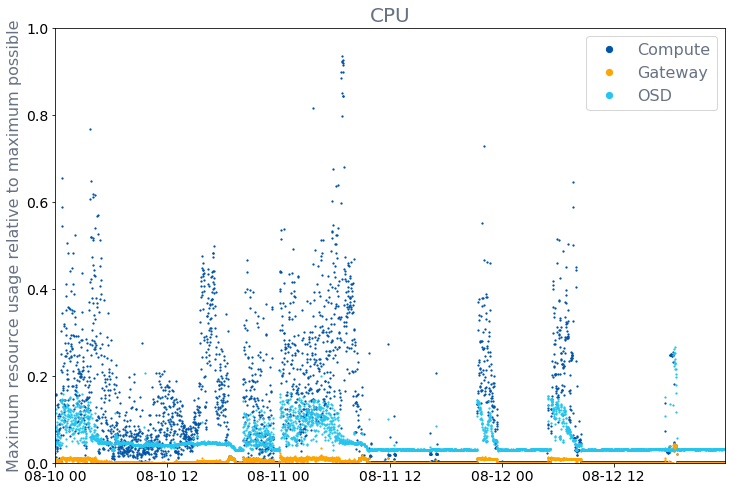

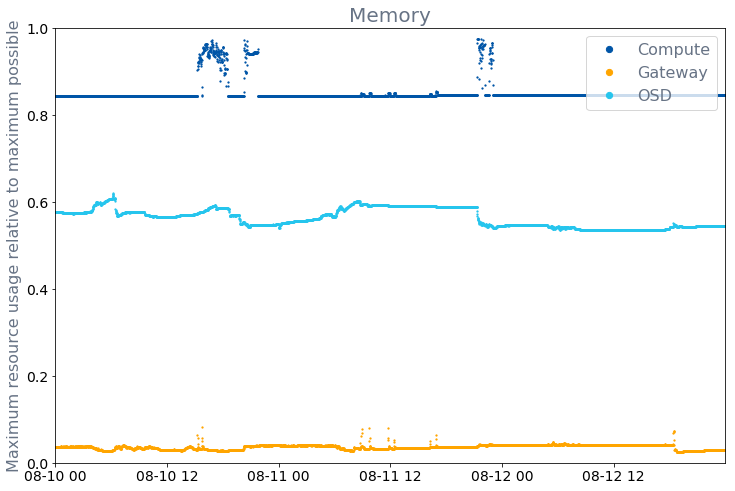

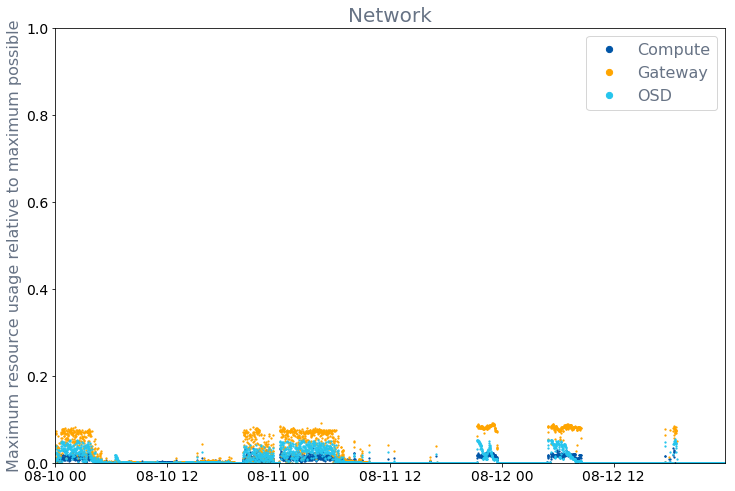

In [19]:
for resource in resources:
    fig, ax = plt.subplots(figsize=(12,8))
    for i, df in enumerate([compute_max, gateway_max, osd_max]):
    
        ax.plot(df[df.server_id==resource].timestamp, 
                df[df.server_id==resource].value, 
                colors[i], label=clusters[i], marker='.', lw=0, markersize=2.5)
    ax.set_title(resource)
    ax.set_ylabel('Maximum resource usage relative to maximum possible')
    ax.set_xlim(pd.to_datetime(t0), pd.to_datetime(t1))
    ax.set_ylim([0,1])
    ax.legend(loc=1, markerscale=5)

OR

## Plot option #2

In [20]:
fig_max, ax_max = plot_multiple([compute_max, gateway_max, osd_max], 
                                t0, t1, [1,1,1], 
                                ['Compute', 'Gateway', 'OSD'], 
                                fig_height=12, title='Server maximum',
                                xlabel='Fraction of maximum resource used')
    

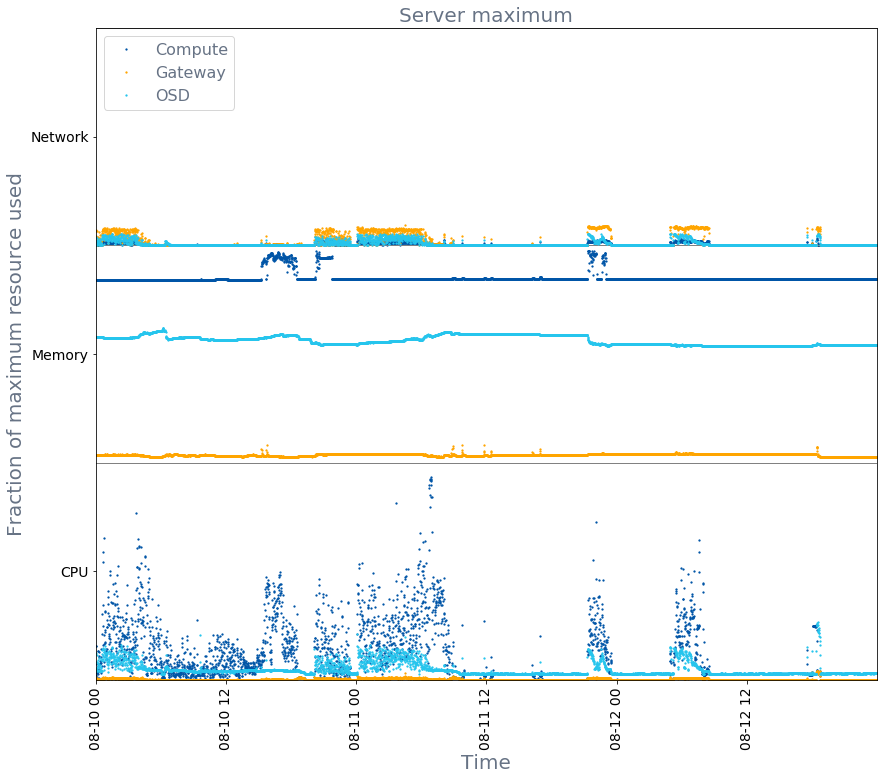

In [21]:
fig_max

Which can be done more quickly using this function: 

In [22]:
# fig_max2, ax_max2 = plot_all([compute, gateway, osd], t0, t1, 
#                            [max_memory, gigabytes*max_memory, network_max],
#                            ['CPU', 'Memory', 'Network'],
#                            ['Compute', 'Gateway', 'OSD'], 
#                            agg_function=np.max,
#                            fig_height=12, title='Server max',
#                            xlabel='Fraction of maximum resource used')

# Mean of servers over time 

In [23]:
fig_mean, ax_mean = plot_all([compute, gateway, osd], t0, t1, 
                           [max_cpu, gigabytes*max_memory, osd_network_max],
                           ['CPU', 'Memory', 'Network'],
                           ['Compute', 'Gateway', 'OSD'], 
                           fig_height=12, title='Server mean',
                           xlabel='Fraction of maximum resource used')

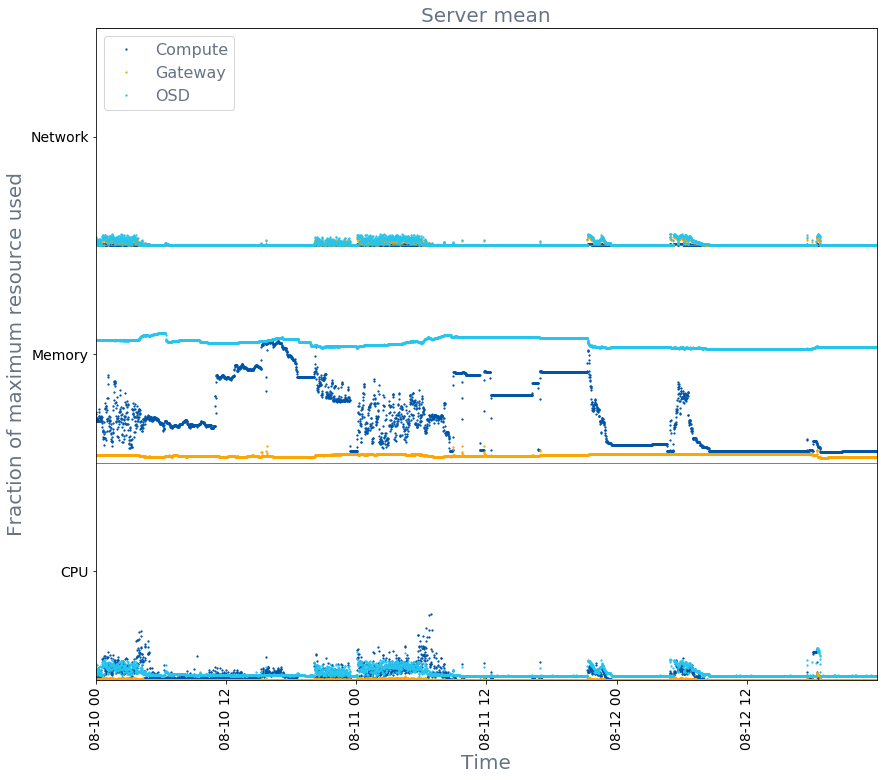

In [24]:
fig_mean